<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [98]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [99]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-04-21 21:17:41--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.001s  

2020-04-21 21:17:42 (18.1 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [100]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [101]:
df.shape

(346, 10)

### Convert to date time object 

In [102]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [103]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [104]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



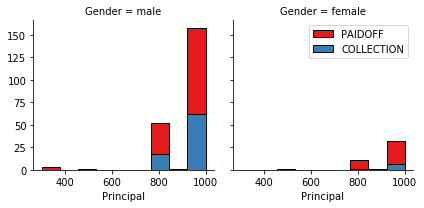

In [110]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

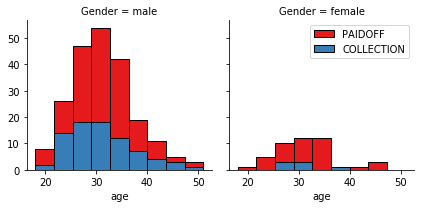

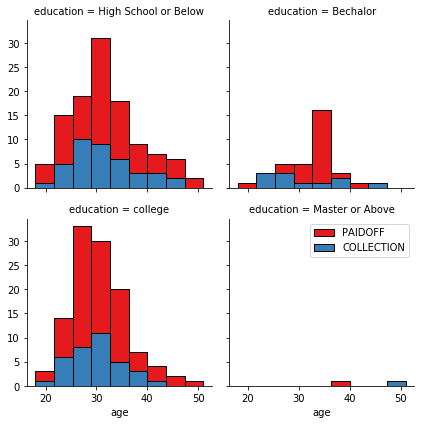

In [111]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

## Test plot for education

bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="education", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

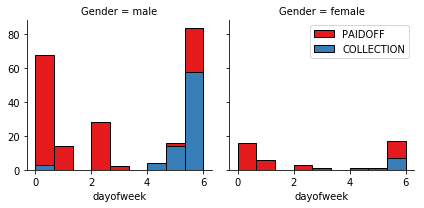

In [112]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [113]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [114]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [115]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [116]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [117]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [118]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [143]:
X = Feature
X[0:5]

## Since we are changing the loan_status making a copy of X
svm_X = X

What are our lables?

In [148]:
y = df['loan_status'].values
y[0:5]

svm_y_df = df
svm_y_df['loan_status'] = svm_y_df['loan_status'].astype('int')
svm_y = np.asarray(svm_y_df['loan_status'])

svm_y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [139]:

X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]


#X.shape
#print("Shape {}, Data {}".format(X.shape,list(X)))

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [122]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [200]:
# Import KNN Lib

from sklearn.neighbors import KNeighborsClassifier


maxK = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
# Running the code upto k = 10

for k in range(1, maxK):

    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
    neigh

    # Predict
    yhat = neigh.predict(X_test)
    yhat[0:5]

    # Accuracy

    from sklearn import metrics
    
    print("For k = {}, Train set Accuracy: {},  Test set Accuracy: {}".format(k,metrics.accuracy_score(y_train, neigh.predict(X_train)),metrics.accuracy_score(y_test, yhat)))
    
    # Now train the model and predict
    
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[k-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[k-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

For k = 1, Train set Accuracy: 0.894927536231884,  Test set Accuracy: 0.6142857142857143
For k = 2, Train set Accuracy: 0.7717391304347826,  Test set Accuracy: 0.5428571428571428
For k = 3, Train set Accuracy: 0.8115942028985508,  Test set Accuracy: 0.6857142857142857
For k = 4, Train set Accuracy: 0.822463768115942,  Test set Accuracy: 0.6
For k = 5, Train set Accuracy: 0.782608695652174,  Test set Accuracy: 0.7285714285714285
For k = 6, Train set Accuracy: 0.7681159420289855,  Test set Accuracy: 0.6857142857142857
For k = 7, Train set Accuracy: 0.7681159420289855,  Test set Accuracy: 0.6857142857142857
For k = 8, Train set Accuracy: 0.7681159420289855,  Test set Accuracy: 0.6857142857142857
For k = 9, Train set Accuracy: 0.7717391304347826,  Test set Accuracy: 0.7428571428571429


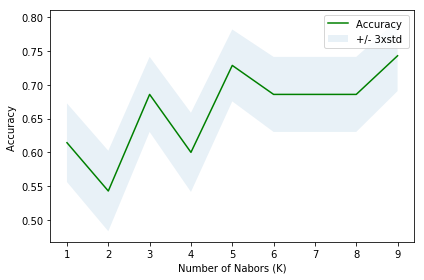

The best accuracy was with 0.7428571428571429 with k= 9


In [201]:
# Lets plot the results

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

# Print the best accuracy
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

# Decision Tree

In [202]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
X = df[['age', 'Gender', 'Principal', 'weekend', 'terms']].values
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

loan_det = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loan_det.fit(X_trainset,y_trainset)

predTree = loan_det.predict(X_testset)

from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  0.7211538461538461


In [189]:
!conda install -c conda-forge pydotplus -y
!conda install -c conda-forge python-graphviz -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    pydotplus-2.0.2            |     pyhd1c1de3_3          23 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.4 MB

The following NEW packages will be INSTALLED:

    pydotplus:       2.0.2-pyhd1c1de3_3 conda-forge
    python_abi:      3.6-1_cp36m        conda-forge

The following packages will be UPDATED:

 

# Support Vector Machine

In [157]:
#print('......',svm_X)

#print('^^^^^^^',y)

# Train/test dataset

X_train, X_test, y_train, y_test = train_test_split( svm_X, svm_y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)
print('Y Test',y_test)
# Lets run the model with RBF and Sigmoid

from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

#After being fitted, the model can then be used to predict new values:

yhat = clf.predict(X_test)

print('Yhat',yhat)
# As a example trying sigmoid

clf1 = svm.SVC(kernel='sigmoid')
clf1.fit(X_train, y_train)
yhat_clf1 = clf1.predict(X_test)
yhat_clf1 [0:5]



Train set: (276, 8) (276,)
Test set: (70, 8) (70,)
Y Test [1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1
 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1 0 1]
Yhat [1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([1, 1, 1, 1, 1])

In [207]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def comp_confusion_matrix(a,b,c):
    cnf_matrix = confusion_matrix(a,b, labels=[0,1])

    np.set_printoptions(precision=2)

    print (classification_report(a,b))

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['Collection(0)','Paidoff(1)'],normalize= False,  title='Confusion matrix ' + c)

____________Confusion Matrix for RBF__________
              precision    recall  f1-score   support

           0       0.20      0.07      0.10        15
           1       0.78      0.93      0.85        55

   micro avg       0.74      0.74      0.74        70
   macro avg       0.49      0.50      0.48        70
weighted avg       0.66      0.74      0.69        70

Confusion matrix, without normalization
[[ 1 14]
 [ 4 51]]
F1 Score for RBF function 0.6892857142857144
Jaccard index for RBF function 0.7428571428571429
__________________SIGMOID____________________
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.79      1.00      0.88        55

   micro avg       0.79      0.79      0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70

Confusion matrix, without normalization
[[ 0 15]
 [ 0 55]]
F1 Score for Sigmoid function 0.69142857

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predic

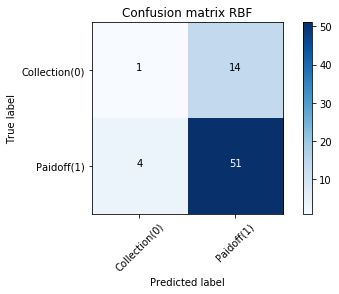

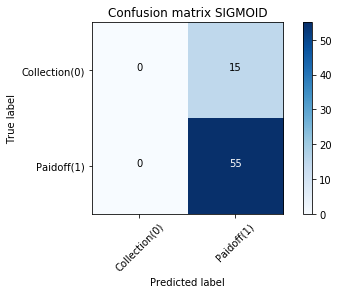

In [208]:
# Compute confusion matrix
print('____________Confusion Matrix for RBF__________')
comp_confusion_matrix(y_test, yhat, 'RBF')

# f1 score
from sklearn.metrics import f1_score
print("F1 Score for RBF function {0}".format(f1_score(y_test, yhat, average='weighted')))


# Jaccard index for aacuracy

from sklearn.metrics import jaccard_similarity_score
print("Jaccard index for RBF function {0}".format(jaccard_similarity_score(y_test, yhat)))


print("__________________SIGMOID____________________")

# Sigmoid
comp_confusion_matrix(y_test, yhat_clf1,'SIGMOID')

# f1 score
from sklearn.metrics import f1_score
print("F1 Score for Sigmoid function {0}".format(f1_score(y_test, yhat_clf1, average='weighted')))

# Jaccard index for aacuracy

from sklearn.metrics import jaccard_similarity_score
print("Jaccard index for Sigmoid function {0}".format(jaccard_similarity_score(y_test, yhat_clf1)))

# Logistic Regression

In [209]:
import scipy.optimize as opt

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LR_Sag_a = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
LR_Sag_a

LR_Sag_b = LogisticRegression(C=0.005, solver='sag').fit(X_train,y_train)
LR_Sag_b

LR_Saga_a = LogisticRegression(C=0.01, solver='saga').fit(X_train,y_train)
LR_Saga_a

LR_Saga_b = LogisticRegression(C=0.005, solver='saga').fit(X_train,y_train)
LR_Saga_b


Train set: (276, 5) (276,)
Test set: (70, 5) (70,)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [211]:
# Predict our values

yhat = LR.predict(X_test)
yhat

yhat_sag_a = LR_Sag_a.predict(X_test)
yhat_sag_b = LR_Sag_b.predict(X_test)

yhat_saga_a = LR_Saga_a.predict(X_test)
yhat_saga_b = LR_Saga_b.predict(X_test)


# predict_proba returns estimates for all classes, ordered by the label of classes. So, the first column is the probability of class 1, P(Y=1|X), and second column is probability of class 0, P(Y=0|X)

yhat_prob = LR.predict_proba(X_test)
yhat_prob

yhat_sag_a_prob = LR_Sag_a.predict_proba(X_test)
yhat_sag_b_prob = LR_Sag_b.predict_proba(X_test)

yhat_saga_a_prob = LR_Saga_a.predict_proba(X_test)
yhat_saga_b_prob = LR_Saga_b.predict_proba(X_test)


#jaccard index

from sklearn.metrics import jaccard_similarity_score

#print("Liblinear jac score {0}, jac sim score {1}".format(jaccard_score(y_test, yhat),jaccard_similarity_score(y_test, yhat)))

#print("Sag jac score {0}, jac sim score {1}".format(jaccard_score(y_test, yhat_sag_a),jaccard_similarity_score(y_test, yhat_sag_a)))
#print("Sag jac score {0}, jac sim score {1}".format(jaccard_score(y_test, yhat_sag_a),jaccard_similarity_score(y_test, yhat_sag_a)))

#print("Saga jac score {0}, jac sim score {1}".format(jaccard_score(y_test, yhat_saga_a),jaccard_similarity_score(y_test, yhat_saga_a)))
#print("Saga jac score {0}, jac sim score {1}".format(jaccard_score(y_test, yhat_saga_b),jaccard_similarity_score(y_test, yhat_saga_b)))
print("Liblinear jac score {0}".format(jaccard_similarity_score(y_test, yhat)))

print("Sag jac score {0}".format(jaccard_similarity_score(y_test, yhat_sag_a)))
print("Saga jac score {0}".format(jaccard_similarity_score(y_test, yhat_saga_b)))


#confusion matrix
#Another way of looking at accuracy of classifier is to look at confusion matrix.

from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
print("liblinear Confusion Matrix {0}".format(confusion_matrix(y_test, yhat, labels=[1,0])))
print("Sag Confusion Matrix {0}".format(confusion_matrix(y_test, yhat_sag_a, labels=[1,0])))
print("Sag 0.005 Confusion Matrix {0}".format(confusion_matrix(y_test, yhat_sag_b, labels=[1,0])))

print("Saga Confusion Matrix {0}".format(confusion_matrix(y_test, yhat_saga_a, labels=[1,0])))
print("Saga 0.005 Confusion Matrix {0}".format(confusion_matrix(y_test, yhat_saga_b, labels=[1,0])))



Liblinear jac score 0.7857142857142857
Sag jac score 0.7857142857142857
Saga jac score 0.7857142857142857
liblinear Confusion Matrix [[55  0]
 [15  0]]
Sag Confusion Matrix [[55  0]
 [15  0]]
Sag 0.005 Confusion Matrix [[55  0]
 [15  0]]
Saga Confusion Matrix [[55  0]
 [15  0]]
Saga 0.005 Confusion Matrix [[55  0]
 [15  0]]


Confusion matrix, without normalization
[[55  0]
 [15  0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.79      1.00      0.88        55

   micro avg       0.79      0.79      0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70

Confusion matrix, without normalization
[[55  0]
 [15  0]]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.79      1.00      0.88        55

   micro avg       0.79      0.79      0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70



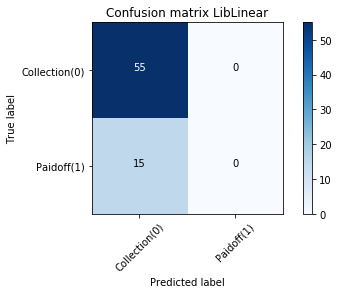

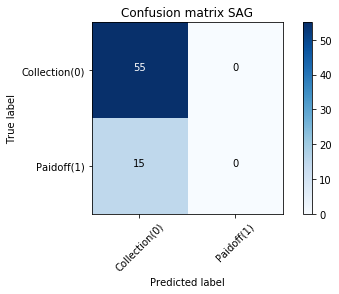

In [213]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Collection(0)','Paidoff(1)'],normalize= False,  title='Confusion matrix LibLinear')

print (classification_report(y_test, yhat))

# Compute confusion matrix , only keep sag_a
cnf_matrix = confusion_matrix(y_test, yhat_sag_a, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Collection(0)','Paidoff(1)'],normalize= False,  title='Confusion matrix SAG')

print (classification_report(y_test, yhat_sag_a))

# Model Evaluation using Test set

In [214]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [215]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-04-22 00:05:39--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-04-22 00:05:39 (180 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [216]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [229]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

# Import KNN Lib

from sklearn.neighbors import KNeighborsClassifier


maxK = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
# Running the code upto k = 10

for k in range(1, maxK):

    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
    neigh

    # Predict
    yhat = neigh.predict(X_test)
    yhat[0:5]

    # Accuracy

    from sklearn import metrics
    
    print("For k = {}, Train set Accuracy: {},  Test set Accuracy: {}".format(k,metrics.accuracy_score(y_train, neigh.predict(X_train)),metrics.accuracy_score(y_test, yhat)))
    
    # Now train the model and predict
    
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[k-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[k-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    
# Jaccard index for aacuracy

from sklearn.metrics import jaccard_similarity_score
KNN_Jaccard_Score = jaccard_similarity_score(y_test, yhat)

# f1 score
from sklearn.metrics import f1_score
KNN_F1_Score = f1_score(y_test, yhat, average='weighted')


# ______________________ Decision Tree


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
X = df[['age', 'Gender', 'Principal', 'weekend', 'terms']].values
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

loan_det = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loan_det.fit(X_trainset,y_trainset)

predTree = loan_det.predict(X_testset)

from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

#jaccard index

from sklearn.metrics import jaccard_similarity_score
decision_Jaccard_Score = jaccard_similarity_score(y_testset, predTree)

from sklearn.metrics import f1_score
decision_F1_Score = f1_score(y_testset, predTree, average='weighted')



# _________________________________________ SVM

# Train/test dataset

X_train, X_test, y_train, y_test = train_test_split( svm_X, svm_y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)

# Lets run the model with RBF and Sigmoid

from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

#After being fitted, the model can then be used to predict new values:

yhat = clf.predict(X_test)

print('Yhat',yhat)

#jaccard index

from sklearn.metrics import jaccard_similarity_score
svm_Jaccard_Score = jaccard_similarity_score(y_test, yhat)

from sklearn.metrics import f1_score
svm_F1_Score = f1_score(y_test, yhat, average='weighted')


Train set: (276, 5) (276,)
Test set: (70, 5) (70,)
For k = 1, Train set Accuracy: 0.8297101449275363,  Test set Accuracy: 0.6571428571428571
For k = 2, Train set Accuracy: 0.75,  Test set Accuracy: 0.5428571428571428
For k = 3, Train set Accuracy: 0.7971014492753623,  Test set Accuracy: 0.6142857142857143
For k = 4, Train set Accuracy: 0.7789855072463768,  Test set Accuracy: 0.6
For k = 5, Train set Accuracy: 0.7789855072463768,  Test set Accuracy: 0.6428571428571429
For k = 6, Train set Accuracy: 0.7789855072463768,  Test set Accuracy: 0.6857142857142857
For k = 7, Train set Accuracy: 0.7717391304347826,  Test set Accuracy: 0.7
For k = 8, Train set Accuracy: 0.7681159420289855,  Test set Accuracy: 0.7
For k = 9, Train set Accuracy: 0.7717391304347826,  Test set Accuracy: 0.7142857142857143
DecisionTrees's Accuracy:  0.7211538461538461
Train set: (276, 8) (276,)
Yhat [1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [232]:
# Logistic regression 


import scipy.optimize as opt

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR


# Predict our values

yhat = LR.predict(X_test)
yhat

# predict_proba returns estimates for all classes, ordered by the label of classes. So, the first column is the probability of class 1, P(Y=1|X), and second column is probability of class 0, P(Y=0|X)

yhat_prob = LR.predict_proba(X_test)
yhat_prob


#jaccard index

from sklearn.metrics import jaccard_similarity_score
logistic_Jaccard_Score = jaccard_similarity_score(y_test, yhat)

from sklearn.metrics import f1_score
logistic_F1_Score = f1_score(y_test, yhat, average='weighted')

from sklearn.metrics import log_loss
logistic_Log_Loss = log_loss(y_test, yhat_prob)


Train set: (276, 5) (276,)
Test set: (70, 5) (70,)


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [236]:
print('Algorithm\t\t Jaccard\t\t F1-Score\t\t LogLoss\n')
print('_______________________________________________________________________________________________')
print('KNN\t\t {0} \t\t {1} \t\t NA'.format(KNN_Jaccard_Score,KNN_F1_Score))
print('Decision Tree\t {0} \t\t {1} \t\t NA'.format(decision_Jaccard_Score,decision_F1_Score))
print('SVM\t\t {0} \t\t {1} \t\t NA'.format(svm_Jaccard_Score,svm_F1_Score))
print('LR\t\t {0} \t\t {1} \t\t {2}'.format(logistic_Jaccard_Score,logistic_F1_Score,logistic_Log_Loss))


Algorithm		 Jaccard		 F1-Score		 LogLoss

_______________________________________________________________________________________________
KNN		 0.7142857142857143 		 0.6720228923618754 		 NA
Decision Tree	 0.7211538461538461 		 0.6204340352385045 		 NA
SVM		 0.7571428571428571 		 0.6978810663021189 		 NA
LR		 0.7857142857142857 		 0.6914285714285714 		 0.5438808232729325


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>